**Goal**: To implement and demonstrate the Byte Pair Encoding (BPE) algorithm for subword tokenization.

In [1]:
import math
import collections
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(42)

Preparing Toy Training Text

In [3]:
text = """
low lower lowest
new newer newest
wide wider widest
"""

In [4]:
text = text.strip().split()
print(text)

['low', 'lower', 'lowest', 'new', 'newer', 'newest', 'wide', 'wider', 'widest']


Initializing Character Vocabulary

In [5]:
def init_vocab(words):
    vocab = {}
    for word in words:
        chars = " ".join(list(word)) + " </w>"
        vocab[chars] = vocab.get(chars, 0) + 1
    return vocab

vocab = init_vocab(text)
vocab

{'l o w </w>': 1,
 'l o w e r </w>': 1,
 'l o w e s t </w>': 1,
 'n e w </w>': 1,
 'n e w e r </w>': 1,
 'n e w e s t </w>': 1,
 'w i d e </w>': 1,
 'w i d e r </w>': 1,
 'w i d e s t </w>': 1}

Count Symbol Pair Frequencies

In [6]:
def get_pair_freqs(vocab):
    pair_freqs = collections.Counter()
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols) - 1):
            pair_freqs[(symbols[i], symbols[i+1])] += freq
    return pair_freqs

In [7]:
get_pair_freqs(vocab)

Counter({('l', 'o'): 3,
         ('o', 'w'): 3,
         ('w', '</w>'): 2,
         ('w', 'e'): 4,
         ('e', 'r'): 3,
         ('r', '</w>'): 3,
         ('e', 's'): 3,
         ('s', 't'): 3,
         ('t', '</w>'): 3,
         ('n', 'e'): 3,
         ('e', 'w'): 3,
         ('w', 'i'): 3,
         ('i', 'd'): 3,
         ('d', 'e'): 3,
         ('e', '</w>'): 1})

Merge the Best Pair

In [8]:
def merge_pair(pair, vocab):
    new_vocab = {}
    bigram = " ".join(pair)
    replacement = "".join(pair)

    for word in vocab:
        new_word = word.replace(bigram, replacement)
        new_vocab[new_word] = vocab[word]
    return new_vocab

Train the BPE Vocabulary

In [9]:
def train_bpe(vocab, num_merges):
    merges = []
    for _ in range(num_merges):
        pair_freqs = get_pair_freqs(vocab)
        if not pair_freqs:
            break
        best_pair = pair_freqs.most_common(1)[0][0]
        vocab = merge_pair(best_pair, vocab)
        merges.append(best_pair)
    return vocab, merges

In [10]:
vocab, merges = train_bpe(vocab, num_merges=10)
merges

[('w', 'e'),
 ('l', 'o'),
 ('r', '</w>'),
 ('s', 't'),
 ('st', '</w>'),
 ('n', 'e'),
 ('w', 'i'),
 ('wi', 'd'),
 ('wid', 'e'),
 ('w', '</w>')]

Build Token to ID Mapping

In [11]:
tokens = set()
for word in vocab:
    tokens.update(word.split())

token2id = {tok: i for i, tok in enumerate(sorted(tokens))}
id2token = {i: tok for tok, i in token2id.items()}

token2id

{'</w>': 0,
 'lo': 1,
 'ne': 2,
 'r</w>': 3,
 'st</w>': 4,
 'w</w>': 5,
 'we': 6,
 'wide': 7}

Token Visualizer

In [12]:
def visualize_tokens(word, merges):
    tokens = list(word) + ["</w>"]
    print("Start:", tokens)

    for pair in merges:
        i = 0
        while i < len(tokens) - 1:
            if tokens[i] == pair[0] and tokens[i+1] == pair[1]:
                tokens[i:i+2] = ["".join(pair)]
            else:
                i += 1
        print(f"Merge {pair} →", tokens)

In [13]:
visualize_tokens("lowest", merges)

Start: ['l', 'o', 'w', 'e', 's', 't', '</w>']
Merge ('w', 'e') → ['l', 'o', 'we', 's', 't', '</w>']
Merge ('l', 'o') → ['lo', 'we', 's', 't', '</w>']
Merge ('r', '</w>') → ['lo', 'we', 's', 't', '</w>']
Merge ('s', 't') → ['lo', 'we', 'st', '</w>']
Merge ('st', '</w>') → ['lo', 'we', 'st</w>']
Merge ('n', 'e') → ['lo', 'we', 'st</w>']
Merge ('w', 'i') → ['lo', 'we', 'st</w>']
Merge ('wi', 'd') → ['lo', 'we', 'st</w>']
Merge ('wid', 'e') → ['lo', 'we', 'st</w>']
Merge ('w', '</w>') → ['lo', 'we', 'st</w>']


One-Hot Embeddings

In [14]:
vocab_size = len(token2id)
one_hot = torch.eye(vocab_size)

In [15]:
#Cosine Similarity
def cosine_matrix(emb):
    norm = emb / emb.norm(dim=1, keepdim=True)
    return norm @ norm.T

In [16]:
cos_one_hot = cosine_matrix(one_hot)

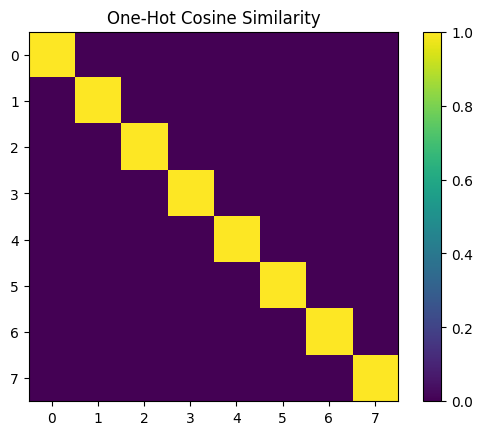

In [17]:
plt.imshow(cos_one_hot)
plt.title("One-Hot Cosine Similarity")
plt.colorbar()
plt.show()

Learned Embeddings

In [18]:
embedding_dim = 8
embed = nn.Embedding(vocab_size, embedding_dim)

learned_emb = embed.weight.detach()
cos_learned = cosine_matrix(learned_emb)

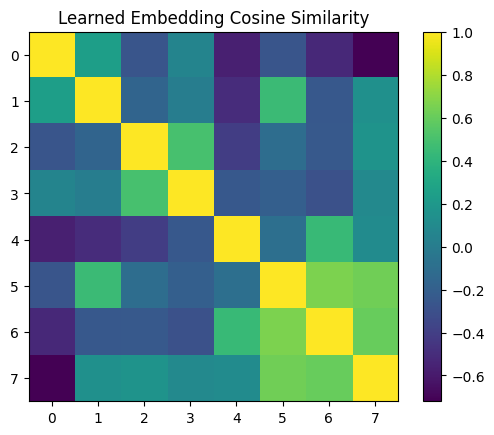

In [19]:
plt.imshow(cos_learned)
plt.title("Learned Embedding Cosine Similarity")
plt.colorbar()
plt.show()

Compare Specific Tokens

In [21]:
def token_similarity(tok1, tok2):
    i, j = token2id[tok1], token2id[tok2]
    return cos_learned[i, j].item()

# Using existing tokens from token2id for demonstration
token_similarity("lo", "we"), token_similarity("lo", "ne")

(-0.2468894124031067, -0.16570323705673218)

## Notebook Summary

**Achieved**:
- Developed functions for BPE vocabulary initialization, pair frequency counting, and merging.
- Trained a BPE vocabulary on a toy dataset.
- Created token-to-ID mappings for the learned subword units.
- Implemented a token visualizer to show the step-by-step merging process.
- Generated and compared cosine similarity visualizations for one-hot and randomly initialized learned embeddings of the BPE tokens.

**Result**: Successfully applied BPE to break down words into subword units, created a token vocabulary, and visualized the initial (random) relationships between these tokens in an embedding space, contrasting them with one-hot representations.